# Project 6: IMDB

This project involves NLP, decision trees, bagging, boosting, and more!

---

## Load packages

You are likely going to need to install the `imdbpie` package:

    > pip install imdbpie

---

In [1]:
import os
import subprocess
import collections
import re
import csv
import json

import pandas as pd
import numpy as np
import scipy

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

import psycopg2
import requests
from imdbpie import Imdb
import nltk

import urllib
from bs4 import BeautifulSoup
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---

## Part 1: Acquire the Data

You will connect to the IMDB API to query for movies. 

See here for documentation on how to use the package:

https://github.com/richardasaurus/imdb-pie

#### 1. Connect to the IMDB API

In [2]:
imdb = Imdb()
imdb = Imdb(anonymize=True) # Anonymize so don't get locked out


#### 2. Query the top 250 rated movies in the database

In [3]:
# Output of the top 250 movies
# Top 250 movies are output as list of json files
# Converting to json makes it easy to put into dataframe

top250 = json.dumps(imdb.top_250())


#### 3. Make a dataframe from the movie data

Keep the fields:

    num_votes
    rating
    tconst
    title
    year
    
And discard the rest

In [4]:
# Can use read_json to import the dump from above
movies250 = (pd.read_json(top250))

# Subset only desired columns
movies = movies250[['num_votes', 'rating', 'tconst', 'title', 'year']]

#### 3. Select only the top 100 movies

In [5]:
movies = movies.ix[0:100,:]

In [6]:
movies.tail()

,num_votes,rating,tconst,title,year
96,408138,8.3,tt0119488,L.A. Confidential,1997
97,153815,8.3,tt0059578,For a Few Dollars More,1965
98,107267,8.3,tt0053604,The Apartment,1960
99,100627,8.3,tt0042876,Rashomon,1950
100,506269,8.3,tt0097576,Indiana Jones and the Last Crusade,1989


#### 4. Get the genres and runtime for each movie and add them to the dataframe


There can be multiple genres per movie, so this will need some finessing.

In [7]:
# Create Empty lists to store genres/runtime
# movies_genres = []
# movies_runtime = []    


# for tconst in movies['tconst']: # iterate through the movie ids
#     title = imdb.get_title_by_id(tconst) # Get title info of id
#     movies_genres.append(title.genres)   # Append genre of id to list
#     movies_runtime.append(title.runtime) # Append the runtime of the title (in seconds)

In [8]:
# movies_genres

In [9]:
# movies['genres'] = movies_genres
# movies['runtime'] = movies_runtime

#### 4. Write the Results to a csv

In [10]:
# movies.to_csv('movies.csv',     # Filepath
#               encoding='utf-8') # use utf-8 encoding

---

## Part 2: Wrangle the text data

#### 1. Scrape the reviews for the top 100 movies

*Hint*: Use a loop to scrape each page at once

In [11]:
import requests
from scrapy.selector import Selector
from scrapy.http import HtmlResponse

url = 'http://www.imdb.com/title/%s/' % 'tt0111161' # Set URL
response = requests.get(url)                        # Get URL Response
HTML = response.text                                # Obtain text from response

In [12]:
# Select Text of Review
Selector(text=HTML).xpath('//span/div[2]/p/text()').extract() 

[u" Can Hollywood, usually creating things for entertainment purposes only, create art?  To create something of this nature, a director must approach it in a most meticulous manner, due to the delicacy of the process.  Such a daunting task requires an extremely capable artist with an undeniable managerial capacity and an acutely developed awareness of each element of art in their films, the most prominent; music, visuals, script, and acting. These elements, each equally important, must succeed independently, yet still form a harmonious union, because this mixture determines the fate of the artist's opus.  Though already well known amongst his colleagues for his notable skills at writing and directing, Frank Darabont emerges with his feature film directorial debut, The Shawshank Redemption.  Proving himself already a master of the craft, Darabont managed to create one of the most recognizable independent releases in the history of Hollywood.  The Shawshank Redemption defines a genre, de

In [13]:
# Select Review Score
Selector(text=HTML).xpath("//div[@class='ratingValue']/strong/span/text()").extract()

[u'9.3']

#### 2. Extract the reviews and the rating per review for each movie

*Note*: "soup" from BeautifulSoup is the html returned from all 25 pages. You'll need to either address each page individually or break them down by elements.

In [14]:
top250= pd.read_csv('movies.csv')

In [15]:
# Reviews for all of the movies are stored as .gif files
# The file name corresponds to a score out of 100

reviews = pd.DataFrame()

url = 'http://www.imdb.com/title/%s/reviews?start=0' % 'tt0111161' # Set URL
response = requests.get(url)                        # Get URL Response
HTML = response.text                                # Obtain text from response


review = []
rank = []
tconsts =[]
for tconst in top250['tconst'].unique():
    url = 'http://www.imdb.com/title/%s/reviews?start=0' % tconst
    response = requests.get(url)
    HTML = response.text   
    for i in range(1,11):
        tconsts.append(tconst)
        review.append((Selector(text=HTML).xpath(
                "//div[@id='tn15content']/p[%s]/text()" % i).extract()[0]).encode('utf-8'))
        rank.append((Selector(text=HTML).xpath("//div[@id='tn15']/div[@id='tn15main']/div[@id='tn15content']/div[%s]/img/@src" % i ).extract()))

In [59]:
reviews = pd.DataFrame(
{'tconst' : tconsts,
'Ranking' : rank,
'Review' : review})

In [60]:
Selector(text=HTML).xpath('//div[1]/img/@src').extract()[0]

u'http://i.media-imdb.com/images/showtimes/100.gif'

In [61]:
reviews.head()

,Ranking,Review,tconst
0,[http://i.media-imdb.com/images/showtimes/100....,\nWhy do I want to write the 234th comment on ...,tt0111161
1,[],"\n\nCan Hollywood, usually creating things for...",tt0111161
2,[http://i.media-imdb.com/images/showtimes/100....,\n\nI have never seen such an amazing film sin...,tt0111161
3,[],"\nIn its Oscar year, Shawshank Redemption (wri...",tt0111161
4,[],\nThe reason I became a member of this databas...,tt0111161


#### 3. Remove the non AlphaNumeric characters from reviews

In [62]:
reviews['Review'] = reviews['Review'].astype(str).convert_objects(convert_numeric=True)

/Users/sebozek/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  if __name__ == '__main__':


In [63]:
reviews['Ranking'] = reviews['Ranking'].astype(str)

In [64]:
reviews['Ranking'] = reviews['Ranking'].apply(lambda x: x[:-1] if len(x) > 2 else np.NaN) # have reviews without ranking as not having value


In [65]:
reviews['Ranking'] = reviews['Ranking'].apply(lambda x: 
                                              re.sub('[^0-9]','', x) if x > 0  # If ranking is not a NaN, take only the numerics
                                              else x)                          # Else return the ranking. 

In [66]:
reviews['Review'] = reviews['Review'].apply(
    lambda x: str(x.replace('\n', '')
                 )) # remove all of the \n present

In [67]:
imdb_reviews = reviews

#### 4. Calculate the top 200 ngrams from the user reviews

Use the `TfidfVectorizer` in sklearn.

Recommended parameters:

    ngram_range = (1, 2)
    stop_words = 'english'
    binary = False
    max_features = 200

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [69]:
review_corpus = ""

for rev in imdb_reviews.Review:
    review_corpus += rev

In [70]:
tfidf  = TfidfVectorizer( 
                ngram_range = (1, 2), # Have n-gram sizes of 1 and two
                stop_words = 'english', # Use english stop words
                binary = False, # Count frequency rather than appearance
                max_features = 200) # Take 200 top words

In [71]:
tfidf.fit_transform(reviews.Review) # fit to each of the 

<1010x200 sparse matrix of type '<type 'numpy.float64'>'
	with 11863 stored elements in Compressed Sparse Row format>

In [72]:
feature_names = tfidf.get_feature_names() 

indices = np.argsort(tfidf.idf_)[::-1]
features = tfidf.get_feature_names()
top_n = 200
top_features = [features[i] for i in indices[:top_n]]
print pd.DataFrame(top_features)

                  0
0             pixar
1              book
2             leone
3             seven
4             fight
5             nolan
6           michael
7             space
8         godfather
9            future
10        hitchcock
11             king
12           robert
13        tarantino
14             city
15             jack
16              use
17        star wars
18   cinematography
19        directors
20             left
21         released
22            drama
23              men
24           ending
25             wars
26             epic
27              guy
28          theater
29           family
..              ...
170       character
171            does
172            know
173           world
174          acting
175            make
176           watch
177      characters
178             don
179             say
180              ve
181             man
182           think
183           years
184          really
185             way
186          people
187            life


#### 5. Merge the user reviews and ratings

In [73]:
imdb_reviews['Rating'] = imdb_reviews.Ranking
del imdb_reviews['Ranking']

In [74]:
imdb_reviews.head()

,Review,tconst,Rating
0,Why do I want to write the 234th comment on Th...,tt0111161,100
1,"Can Hollywood, usually creating things for ent...",tt0111161,NaN
2,I have never seen such an amazing film since I...,tt0111161,100
3,"In its Oscar year, Shawshank Redemption (writt...",tt0111161,NaN
4,The reason I became a member of this database ...,tt0111161,NaN


#### 6. Save this merged dataframe as a csv

In [75]:
imdb_reviews.to_csv('ratings.csv')

---

## Part 3: Combine Tables in PostgreSQL

#### 1. Import your two .csv data files into your Postgre Database as two different tables

For ease, we can call these table1 and table2

#### 2. Connect to database and query the joined set

#### 3. Join the two tables 

#### 4. Select the newly joined table and save two copies of the into dataframes

---

## Part 4: Parsing and Exploratory Data Analysis

#### 1. Rename any columns you think should be renamed for clarity

In [94]:
movies = pd.read_csv('movies.csv')

In [95]:
imdb_100 = pd.merge(imdb_reviews, movies, how='left')

In [104]:
imdb_100.describe()

,Rating,Unnamed: 0,num_votes,rating,year,runtime
count,405.000000,1010.000000,1.010000e+03,1010.000000,1010.000000,1010.000000
mean,96.641975,50.000000,5.701886e+05,8.530693,1982.029703,7876.039604
std,12.169704,29.169203,3.707873e+05,0.204868,22.357336,1889.072472
min,10.000000,0.000000,6.136100e+04,8.300000,1921.000000,4080.000000
25%,100.000000,25.000000,2.436180e+05,8.400000,1965.000000,6540.000000
50%,100.000000,50.000000,5.240850e+05,8.500000,1988.000000,7740.000000
75%,100.000000,75.000000,8.082930e+05,8.600000,2000.000000,9060.000000
max,100.000000,100.000000,1.658283e+06,9.300000,2014.000000,14340.000000


In [97]:
imdb_100['Rating'] = imdb_100['Rating'].map(float)

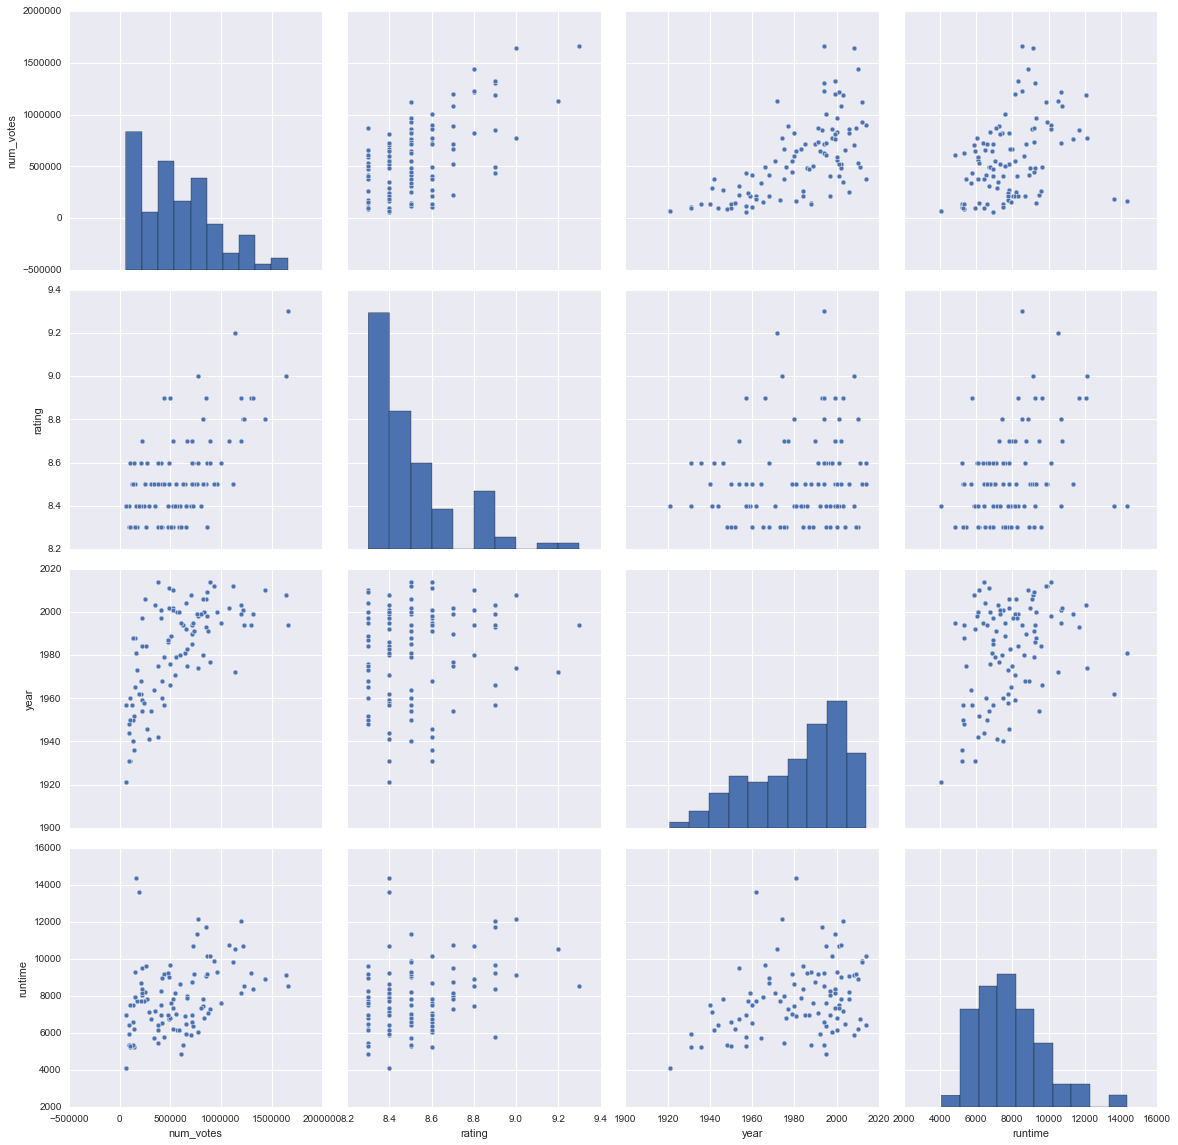

In [103]:
sns.pairplot(imdb_100[[ 
                       'num_votes', 
                       'rating',
        'year',
        'runtime']], size = 4)

#### 2. Describe anything interesting or suspicious about your data (quality assurance)

Newer movies tend to have a much higher participation of voters. Likely due to the fact that people who would watch older movies would be less likely to 

#### 3. Make four visualizations of interest to you using the data

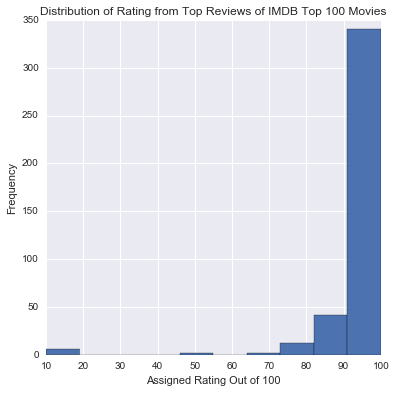

In [124]:
imdb_100['Rating'][imdb_100['Rating'] > 0].plot(kind='hist', figsize = (6,6))
plt.title("Distribution of User Ratings from Top Reviews of IMDB Top 100 Movies")
plt.xlabel("Assigned Rating Out of 100")
plt.show()

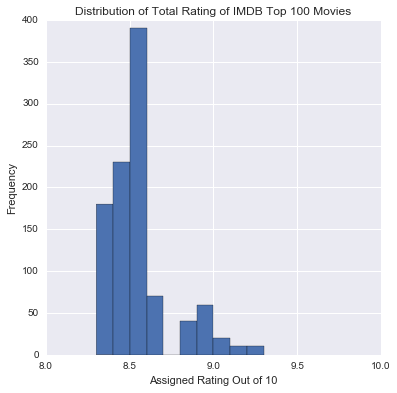

In [130]:
imdb_100['rating'][imdb_100['rating'] > 0].plot(kind='hist', figsize = (6,6))
plt.title("Distribution of Total Rating of IMDB Top 100 Movies")
plt.xlabel("Assigned Rating Out of 10")
plt.xlim(8.0, 10)
plt.show()

*It can be seen that from the above the distribution of the most popular movies is much more rigorous when put together. The people who have the highest ranking reviews tended to give the movie a perfect score. When put together with people at large, it was much more

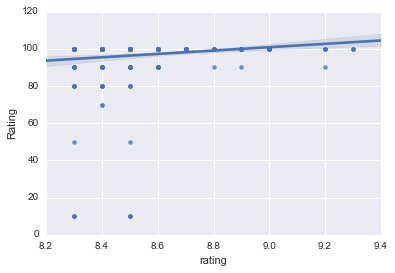

In [135]:
sns.regplot(y = imdb_100['Rating'][imdb_100['Rating'] > 0], x = imdb_100['rating'][imdb_100['Rating'] > 0])

---

## Part 5: Decision Tree Classifiers and Regressors

#### 1. What is our target attribute? 

The target in this case are movies that scored 8.8 / 10 or above. 

#### 2. Prepare the X and Y matrices and preprocess data as you see fit

In [260]:
from sklearn.cross_validation import train_test_split
Y = imdb_100['rating']
X = imdb_100[['year', 'num_votes', 'runtime']].values



In [272]:
Y = np.array(Y)
Y.shape

(1010,)

#### 3. Build and cross-validate your decision tree classifier

In [308]:
Y = np.reshape(Y, (1010,1))
Y.shape

(1010, 1)

In [309]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

X_train, x_test, Y_train, y_test = train_test_split(X, Y, test_size=0.3)

tree = DecisionTreeClassifier()

In [310]:
tree.fit(X_train)

TypeError: fit() takes at least 3 arguments (2 given)

#### 4. Gridsearch optimal parameters for your classifier. Does the performance improve?

In [ ]:

params = {'max_depth' : [3,5,10,15, None],
    'min_samples_split' : [2,3,4],
          'criterion' : ['gini', 
                        'entropy'],
}

#### 5. Build and cross-validate your decision tree regressor

In [284]:
tree_reg = DecisionTreeRegressor(max_depth=5)

In [285]:
tree_reg.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [286]:
y_pred = tree_reg.predict(x_test)

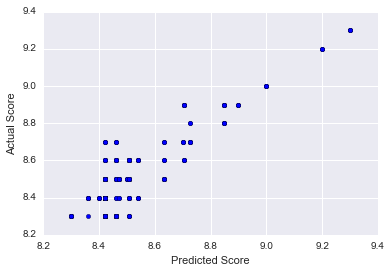

In [287]:
plt.scatter(x=y_pred, y=y_test)
plt.xlabel("Predicted Score")
plt.ylabel("Actual Score")
plt.show()

#### 6. Gridsearch the optimal parameters for your regressor. Does performance improve?

In [301]:
tree_reg = DecisionTreeRegressor()
params = {'max_depth' : [3,5,10,15, None],
    'min_samples_split' : [2,3,4],
          'splitter' : ['best', 
                        'random'],
}

In [302]:
tree_reg_gs = GridSearchCV(tree_reg, params, cv=5)

In [303]:
tree_reg_gs.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'min_samples_split': [2, 3, 4], 'splitter': ['best', 'random'], 'max_depth': [3, 5, 10, 15, None]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

---

## Part 6: Elastic Net


#### 1. Gridsearch optimal parameters for an ElasticNet using the regression target and predictors you used for the decision tree regressor.


In [245]:
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import ElasticNet

net = ElasticNet()
params = {'alpha' : np.logspace(-2,0,20),
         'l1_ratio' : np.logspace(-2,0,20),
         'normalize' : [True, False],
         'fit_intercept' : [True, False]}

net_GS = GridSearchCV(net, params, cv=5)

In [246]:
net_GS.fit(X,Y)

GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': [True, False], 'alpha': array([ 0.01   ,  0.01274,  0.01624,  0.02069,  0.02637,  0.0336 ,
        0.04281,  0.05456,  0.06952,  0.08859,  0.11288,  0.14384,
        0.1833 ,  0.23357,  0.29764,  0.37927,  0.48329,  0.61585,
        0.78476,  1.     ]), 'fit_intercept': [Tru...384,
        0.1833 ,  0.23357,  0.29764,  0.37927,  0.48329,  0.61585,
        0.78476,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

#### 2. Is cross-validated performance better or worse than with the decision trees? 

<bound method GridSearchCV.score of GridSearchCV(cv=5, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'normalize': [True, False], 'alpha': array([ 0.01   ,  0.01274,  0.01624,  0.02069,  0.02637,  0.0336 ,
        0.04281,  0.05456,  0.06952,  0.08859,  0.11288,  0.14384,
        0.1833 ,  0.23357,  0.29764,  0.37927,  0.48329,  0.61585,
        0.78476,  1.     ]), 'fit_intercept': [Tru...384,
        0.1833 ,  0.23357,  0.29764,  0.37927,  0.48329,  0.61585,
        0.78476,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)>

#### 3. Explain why the elastic net may have performed best at that particular l1_ratio and alpha

---

## Part 7: Bagging and Boosting: Random Forests, Extra Trees, and AdaBoost

#### 1. Load the random forest regressor, extra trees regressor, and adaboost regressor from sklearn

In [139]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor

#### 2. Gridsearch optimal parameters for the three different ensemble methods.

In [324]:
ran_for = RandomForestRegressor()
ran_params = {
    'n_estimators' : [5,10,15,20],
    'max_depth' : [3,5,10,15, None],
    'bootstrap' : [True, False]
}
ran_gs = GridSearchCV(ran_for, ran_params, cv=5)

ext_for = ExtraTreesRegressor()
ext_params = {
    'n_estimators' : [5,10,15,20],
    'max_depth' : [3,5,10,15, None],
    'bootstrap' : [True, False]
}
ext_gs = GridSearchCV(ext_for, ext_params, cv=5)

ada = AdaBoostRegressor()
ada_params = {
    'n_estimators' : [5,10,15,20],
    'loss' : ['linear', 'square', 'exponential'],
    'learning_rate' : np.logspace(-1,1,10)
}
ada_gs = GridSearchCV(ada, ada_params, cv=5)

#### 3. Evaluate the performance of the two bagging and one boosting model. Which performs best?

In [338]:
ran = ran_gs.fit(X, np.ravel(Y))

In [339]:
ran.best_score_

-14.193893226401142

In [330]:
ext = ext_gs.fit(X, np.ravel(Y))

In [332]:
ext.best_score_

-11.791740922058533

In [333]:
ada = ada_gs.fit(X, np.ravel(Y))

In [336]:
ada.best_score_

-11.652399724986163

#### 4. Extract the feature importances from the Random Forest regressor and make a DataFrame pairing variable names with their variable importances.

In [342]:
ran.

5

#### 5. Plot the ranked feature importances.

#### 6.1 [BONUS] Gridsearch an optimal Lasso model and use it for variable selection (make a new predictor matrix with only the variables not zeroed out by the Lasso). 

#### 6.2 [BONUS] Gridsearch your best performing bagging/boosting model from above with the features retained after the Lasso. Does the score improve?

#### 7.1. [BONUS] Select a threshold for variable importance from your Random Forest regressor and use that to perform feature selection, creating a new subset predictor matrix.

#### 7.2 [BONUS] Using BaggingRegressor with a base estimator of your choice, test a model using the feature-selected dataset you made in 7.1

---

## [VERY BONUS] Part 8: PCA

#### 1. Perform a PCA on your predictor matrix

#### 2. Examine the variance explained and determine what components you want to keep based on them.

#### 3. Plot the cumulative variance explained by the ordered principal components.

#### 4. Gridsearch an elastic net using the principal components you selected as your predictors. Does this perform better than the elastic net you fit earlier?

#### 5. Gridsearch a bagging ensemble estimator that you fit before, this time using the principal components as predictors. Does this perform better or worse than the original? 

#### 6. Look at the loadings of the original predictor columns on the first 3 principal components. Is there any kind of intuitive meaning here?

Hint, you will probably want to sort by absolute value of magnitude of loading, and also only look at the obviously important (larger) ones!

# [Extremely Bonus] Part 9:  Clustering

![](https://snag.gy/jPSZ6U.jpg)

 ***Bonus Bonus:***
This extended bonus question is asking to do something we never really talked about but would like for you to attempt based on the assumptions that we learned during this weeks clustering lesson(s).

#### 1. Import your favorite clustering module

#### 2. Encode categoricals

#### 3. Evaluate cluster metics solely based on a range of K
If K-Means:  SSE/Inertia vs Silhouette (ie: Elbow), silhouette average, etc

#### 4.  Look at your data based on the subset of your predicted clusters.
Assign the cluster predictions back to your dataframe in order to see them in context.  This is great to be able to group by cluster to get a sense of the data that clumped together.

#### 5. Describe your findings based on the predicted clusters 
_How well did it do?  What's good or bad?  How would you improve this? Does any of it make sense?_